# Using CNN for detection on one-minute files

Aim is to run the pre-trained CNN on 'real' one-minute test files, to see how it performs.

Of course I haven't done any hard negative mining or anything like that yet so there is a lot of things to do...

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import numpy as np
import scipy.io
import cPickle as pickle

from scipy.ndimage.interpolation import zoom
from time import time

sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
from engaged.features import features, evaluation

from nolearn.lasagne import objective
from lasagne.layers import get_all_params

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

Using gpu device 0: GeForce GTX 770


## Loading in train and test split

We only want to run the CNN on files from the test split

In [2]:
savedir = '/home/michael/projects/engaged_hackathon_data/detection/train_test_patches/'
base_path = '/home/michael/projects/engaged_hackathon_data/raw_data/one_minute_files/'
split = scipy.io.loadmat(savedir + 'split.mat')
split['test_files'] = [xx.strip() for xx in split['test_files']]

## Analyse the distribution of biotic sounds in ground truth

i.e. how much biotic sound even is there in the test dataset?

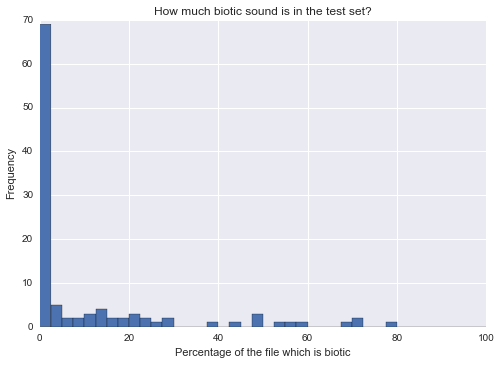

In [3]:
# for each test file, load in the ground truth and see what percentage is actually biotic
has_biotic = []  # list of files which have biotic 
percentages = []  # list of percentages
for fname in split['test_files']:
    
    # load in the ground truth labelling and see how much biotic sound there is
    gt = scipy.io.loadmat(base_path + '/detection_challenge/' + fname + '.mat')
    percentages.append(gt['biotic'].mean() * 100)
    
    # keep track of which files have a 'lot' of biotic noise
    if gt['biotic'].mean() > 0.1:
        has_biotic.append(fname)
    
plt.hist(percentages, np.linspace(0, 100, 41))
plt.xlabel('Percentage of the file which is biotic')
plt.ylabel('Frequency')
plt.title('How much biotic sound is in the test set?');

## Load one file and show the spectrogram and ground truth

RM14-3YB-944_1_20130612_140700_000
(128, 1496)


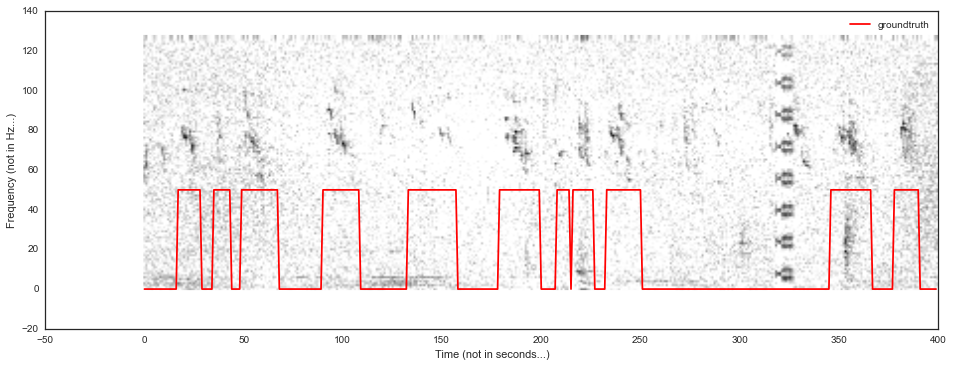

In [4]:
# Just do one file for now. Load in spectrogram...
fname = has_biotic[10]
print fname

base_path = '/home/michael/projects/engaged_hackathon_data/raw_data/one_minute_files'
spec_path = '/home/michael/projects/engaged_hackathon_data/detection/spectrograms/'

# load in spec and also the gt labels
spec = scipy.io.loadmat(spec_path + fname + '_spec_128.mat')['spectrogram']
print spec.shape
# smallspec = scipy.io.loadmat(spec_path + fname + '_smallspec.mat')['spectrogram']
gt = scipy.io.loadmat(base_path + '/detection_challenge/' + fname + '.mat')
    
# convert the labels to the sampling rate of the spectrogram
zoom_factor = float(spec.shape[1]) / float(gt['biotic'][0].shape[0])
gt_biotic = zoom(gt['biotic'][0], zoom_factor).astype(float)

plt.figure(figsize=(16, 10))
with sns.axes_style("white"):
    plt.imshow(spec[:, :400], cmap=plt.get_cmap('gray_r'))
plt.plot(gt_biotic[:400] * 50, 'r', label='groundtruth')
plt.gca().invert_yaxis()
# plt.xlim(0, 400)
# plt.ylim(0, 75)
plt.legend()
plt.xlabel('Time (not in seconds...)')
plt.ylabel('Frequency (not in Hz...)');

## Load in the pre-trained CNN

In [5]:
# I need to redefine this reg objective due to the 
# pickling, will see if I can avoid doing this...
def regularization_objective(layers, lambda1=0., lambda2=0., *args, **kwargs):
    # default loss
    losses = objective(layers, *args, **kwargs)
    # get the layers' weights, but only those that should be regularized
    # (i.e. not the biases)
    weights = get_all_params(layers[-1], regularizable=True)
    # sum of absolute weights for L1
    sum_abs_weights = sum([abs(w).sum() for w in weights])
    # sum of squared weights for L2
    sum_squared_weights = sum([(w ** 2).sum() for w in weights])
    # add weights to regular loss
    losses += lambda1 * sum_abs_weights + lambda2 * sum_squared_weights
    return losses

modeldir = '/home/michael/projects/engaged_hackathon_data/detection/models/'
net = pickle.load(open(modeldir + 'cnn_' + 'full' + '.pkl'))

## Extract patches from the test file and classify

In [6]:
patches = features.extract_1d_patches(spec, range(spec.shape[1]), 9)
S = patches.shape
patches = patches.reshape((S[0], 1, S[1], S[2])).astype(np.float32)

print patches.shape

# apply the model to the single test file
pred_y = net.predict_proba(patches)[:, 1]

(1496, 1, 128, 19)


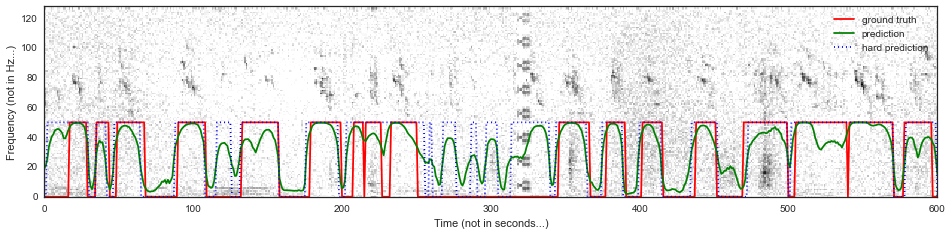

In [7]:
plt.figure(figsize=(16, 10))

t_start, t_end = 500, 600

with sns.axes_style('white'):
    plt.imshow(spec, cmap=plt.get_cmap('gray_r'), interpolation='nearest')
plt.plot(gt_biotic * 50, 'r', label='ground truth')
plt.plot(pred_y * 50, 'g', label='prediction')
plt.plot((pred_y>0.5) * 50, 'b:', label='hard prediction')
plt.gca().invert_yaxis()
plt.xlim(0, 600)
plt.ylim(0, 128)
plt.xlabel('Time (not in seconds...)')
plt.ylabel('Frequency (not in Hz...)');
plt.legend(loc='best');

### Biotic sounds

In [8]:
import scipy.io.wavfile
import IPython
wav_base_path = '/home/michael/projects/engaged_hackathon_data/raw_data/one_minute_files'
sr, wav = scipy.io.wavfile.read(wav_base_path + '/25_Random/' + fname + '.wav')

# snip up to find the predictions
factor = wav.shape[0] / float(pred_y.shape[0])
pred_y_rescaled = zoom(pred_y, factor)

biotic_wav = wav[pred_y_rescaled > 0.5]
scipy.io.wavfile.write('/home/michael/Dropbox/engage/biotic.wav', sr, biotic_wav)
IPython.display.Audio(data=biotic_wav, rate=sr)

### Non biotic sounds

In [9]:
non_biotic_wav = wav[pred_y_rescaled < 0.5]
scipy.io.wavfile.write('/home/michael/Dropbox/engage/non_biotic.wav', sr, non_biotic_wav)
IPython.display.Audio(data=non_biotic_wav, rate=sr)

### Accuracies on this one file

In [10]:
print accuracy_score(gt_biotic, pred_y>0.5)

# do normalised accuracy...
def norm_acc(gt, pred):
    if (gt==0).sum() > 0:
        a = 1.0 - pred[gt==0].mean()
    else:
        a = 1.0
        
    if (gt==1).sum() > 0:
        b = pred[gt==1].mean()
    else:
        b = 1.0
    return (a + b)/2

print norm_acc(gt_biotic, pred_y)
print norm_acc(gt_biotic, pred_y>0.5)

0.782754010695
0.717526033521
0.785154462243


In [11]:
conf = confusion_matrix(gt_biotic, pred_y>0.5)
print conf
sns.set_style("darkgrid")

[[483 277]
 [ 48 688]]


## Evaluate accuracy over all the test files 

In [12]:
# now do for each possible test file:
import collections
accs = []
norm_accs = []
lens = []
sample_results = collections.defaultdict(list)
results = []

for count, fname in enumerate(split['test_files']):

    # load the spec and gt
    spec = scipy.io.loadmat(spec_path + fname + '_spec_128.mat')['spectrogram']
    gt = scipy.io.loadmat(base_path + '/detection_challenge/' + fname + '.mat')

    # convert the labels to the sampling rate of the spectrogram
    zoom_factor = float(spec.shape[1]) / float(gt['biotic'][0].shape[0])
    gt_biotic = zoom(gt['biotic'][0], zoom_factor).astype(float)

    # extracting the patches
    patches = features.extract_1d_patches(spec, range(spec.shape[1]), 9)
    S = patches.shape
    patches = patches.reshape((S[0], 1, S[1], S[2])).astype(np.float32)
    print patches.shape

    #  classify
    pred_y = net.predict_proba(patches)[:, 1]
    
    accs.append(accuracy_score(gt_biotic, pred_y>0.5))
    norm_accs.append(norm_acc(gt_biotic, pred_y>0.5))
    lens.append(evaluation.eval_seconds(gt_biotic, pred_y, 60.0))
    
    # loading the audio and rescaling
    sr, wav = scipy.io.wavfile.read(wav_base_path + '/25_Random/' + fname + '.wav')
    factor = wav.shape[0] / float(pred_y.shape[0])
    pred_y_rescaled = zoom(pred_y, factor)
    
    # add to the tp etc
    sample_results['tp'].append(wav[np.logical_and(gt['biotic'][0]==1, pred_y_rescaled>0.5)])
    sample_results['tn'].append(wav[np.logical_and(gt['biotic'][0]==0, pred_y_rescaled<0.5)])
    sample_results['fp'].append(wav[np.logical_and(gt['biotic'][0]==0, pred_y_rescaled>0.5)])
    sample_results['fn'].append(wav[np.logical_and(gt['biotic'][0]==1, pred_y_rescaled<0.5)])
    
    results.append((gt['biotic'][0], pred_y_rescaled))
    
    print count,

(1496, 1, 128, 19)
0 (1496, 1, 128, 19)
1 (1496, 1, 128, 19)
2 (1496, 1, 128, 19)
3 (1496, 1, 128, 19)
4 (1496, 1, 128, 19)
5 (1496, 1, 128, 19)
6 (1496, 1, 128, 19)
7 (1496, 1, 128, 19)
8 (1496, 1, 128, 19)
9 (1496, 1, 128, 19)
10 (1496, 1, 128, 19)
11 (1496, 1, 128, 19)
12 (1496, 1, 128, 19)
13 (1496, 1, 128, 19)
14 (1496, 1, 128, 19)
15 (1496, 1, 128, 19)
16 (1496, 1, 128, 19)
17 (1496, 1, 128, 19)
18 (1496, 1, 128, 19)
19 (1496, 1, 128, 19)
20 (1496, 1, 128, 19)
21 (1496, 1, 128, 19)
22 (1496, 1, 128, 19)
23 (1496, 1, 128, 19)
24 (1496, 1, 128, 19)
25 (1496, 1, 128, 19)
26 (1496, 1, 128, 19)
27 (1496, 1, 128, 19)
28 (1496, 1, 128, 19)
29 (1496, 1, 128, 19)
30 (1496, 1, 128, 19)
31 (1496, 1, 128, 19)
32 (1496, 1, 128, 19)
33 (1496, 1, 128, 19)
34 (1496, 1, 128, 19)
35 (1496, 1, 128, 19)
36 (1496, 1, 128, 19)
37 (1496, 1, 128, 19)
38 (1496, 1, 128, 19)
39 (1496, 1, 128, 19)
40 (1496, 1, 128, 19)
41 (1496, 1, 128, 19)
42 (1496, 1, 128, 19)
43 (1496, 1, 128, 19)
44 (1496, 1, 128, 19)
4

/home/michael/anaconda/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:549: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


(0,)


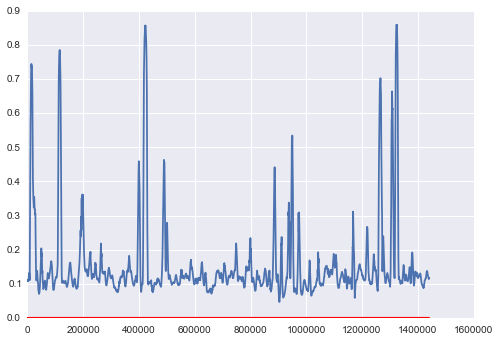

In [13]:
plt.plot(pred_y_rescaled)
plt.plot(gt['biotic'][0], 'r')
print wav[np.logical_and(gt['biotic'][0]==0, pred_y_rescaled==0)].shape

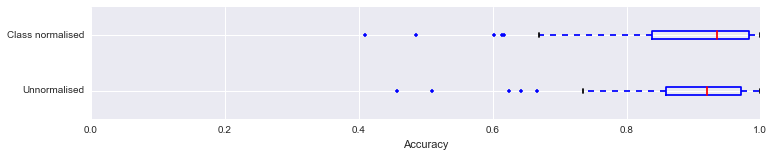

In [14]:
plt.figure(figsize=(12, 2))
plt.boxplot([accs, norm_accs], 0, 'b.', 0);
plt.gca().set_yticklabels(['Unnormalised', 'Class normalised'])
plt.xlim(0, 1)
plt.xlabel('Accuracy')

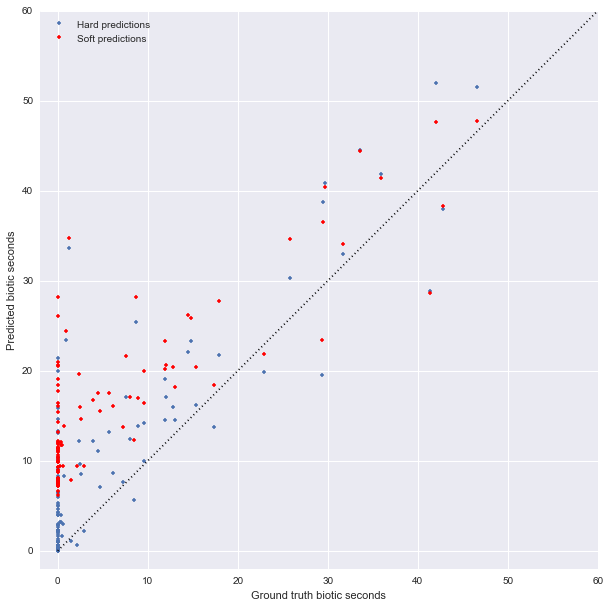

In [15]:
bi_s = np.array([l['biotic'] for l in lens])
pred_s = np.array([l['predicted'] for l in lens])
pred_hard_s = np.array([l['predicted_hard'] for l in lens])

plt.figure(figsize=(10, 10))

plt.plot(bi_s, pred_hard_s, '.', label='Hard predictions')
plt.plot(bi_s, pred_s, '.r', label='Soft predictions')
plt.xlabel('Ground truth biotic seconds')
plt.ylabel('Predicted biotic seconds')
plt.xlim(-2, 60)
plt.ylim(-2, 60)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot([0, 60], [0, 60], 'k:')
plt.legend(loc='best')

In [47]:
# doing the same but for subsets of files...

num_snips = 10000
summaries = []
files_used = []

for count in range(num_snips):
    
    # choose file to extract snippet from...
    result_idx = np.random.choice(len(results))
    files_used.append(result_idx)
    this_gt, this_pred = results[result_idx]
    this_file_length = this_gt.shape[0]
    
    # choose length of snippet
    this_length_seconds = np.random.randint(1, 60)
    this_snip_length = int(this_length_seconds * sr)
        
    # extract snippet from prediction and ground truth
    start_loc = np.random.randint(0, this_file_length - this_snip_length)
    gt_snip = this_gt[start_loc:start_loc+this_snip_length]
    pred_snip = this_pred[start_loc:start_loc+this_snip_length]
    
    # now add the summaries to the summary list...
    summaries.append(evaluation.eval_seconds(gt_snip, pred_snip, gt_snip.shape[0] / float(sr)))
    if count % 10 == 0:
        print count

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

10000


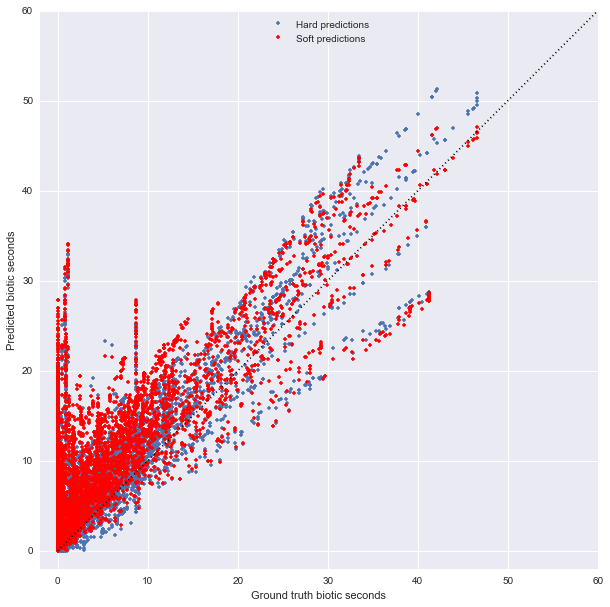

In [48]:
print len(summaries)
bi_s = np.hstack([l['biotic'] for l in summaries]).ravel()
pred_s = np.hstack([l['predicted'] for l in summaries]).ravel()
pred_hard_s = np.hstack([l['predicted_hard'] for l in summaries]).ravel()

plt.figure(figsize=(10, 10))
plt.plot(bi_s, pred_hard_s, '.', label='Hard predictions')
plt.plot(bi_s, pred_s, '.r', label='Soft predictions')
plt.xlabel('Ground truth biotic seconds')
plt.ylabel('Predicted biotic seconds')
plt.xlim(-2, 60)
plt.ylim(-2, 60)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot([0, 60], [0, 60], 'k:')
plt.legend(loc='upper center')
plt.show()

In [95]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor

feats = ['predicted', 'predicted_hard', 'soft_variance', 'soft_binning']

all_reg_gts = []
all_reg_preds = []
all_reg_simple = []

for seed in range(10):

    # creating the full X and Y sets
    X, y = [], []

    for summ in summaries:
        y.append(summ['biotic'])    
        X.append(np.hstack([summ[feat] for feat in feats]))

    X = np.vstack(X)
    y = np.hstack(y)
    print X.shape, y.shape

    # split test set into eg_train and reg_test
    files_used = np.array(files_used)
    train_files, test_files = \
        train_test_split(np.unique(files_used), test_size=0.2, random_state=seed)

    test_file_idxs = np.array([count for count, xx in enumerate(files_used) if xx in test_files])
    train_file_idxs = np.array([count for count, xx in enumerate(files_used) if xx in train_files])

    reg = {}
    reg['test_X'] = X[test_file_idxs, :]
    reg['test_y'] = y[test_file_idxs]
    reg['train_X'] = X[train_file_idxs, :]
    reg['train_y'] = y[train_file_idxs]

    # for key, val in reg.iteritems():
    #     print key, val.shape, val.dtype
    # train a forest on the stats from reg_train
    rf = RandomForestRegressor(n_estimators=50)
    rf.fit(reg['train_X'], reg['train_y'])

    # test on the test set...
    y_pred = rf.predict(reg['test_X'])

    all_reg_gts.append(reg['test_y'])
    all_reg_preds.append(y_pred)
    all_reg_simple.append(reg['test_X'][:, 0].ravel())

(10000, 13) (10000,)
(10000, 13) (10000,)
(10000, 13) (10000,)
(10000, 13) (10000,)
(10000, 13) (10000,)
(10000, 13) (10000,)
(10000, 13) (10000,)
(10000, 13) (10000,)
(10000, 13) (10000,)
(10000, 13) (10000,)


(19966,)
(10,)


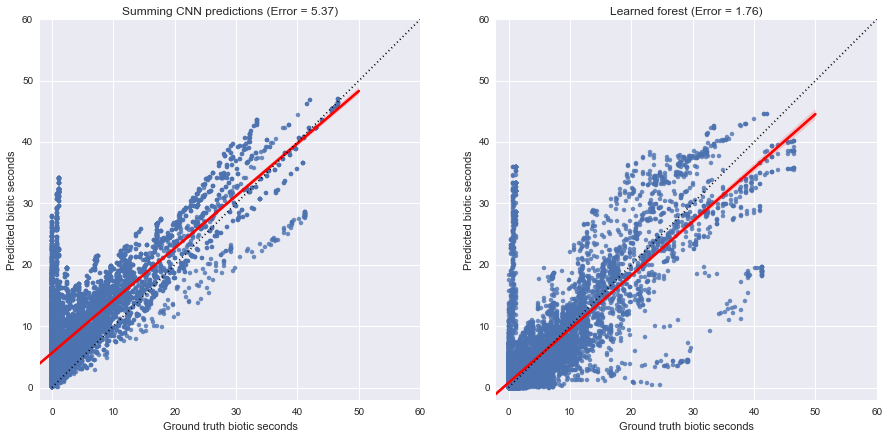

In [131]:
from sklearn import metrics

def plot_reg(gt, pred, title=""):

    sns.regplot(x=gt, y=pred, x_jitter=.0, y_jitter=.0, line_kws={'color': 'r'});

    plt.xlim(-2, 60)
    plt.ylim(-2, 60)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.plot([0, 60], [0, 60], 'k:')
    
    plt.xlabel('Ground truth biotic seconds')
    plt.ylabel('Predicted biotic seconds')
    
    plt.title(title + " (Error = %0.2f"  % metrics.mean_absolute_error(gt, pred) + ")")


plt.figure(figsize=(15, 10))

print np.hstack(all_reg_gts).shape
print np.array(all_reg_preds).shape

plt.subplot(121)
plot_reg(np.hstack(all_reg_gts), np.hstack(all_reg_simple), 'Summing CNN predictions')
plt.subplot(122)
plot_reg(np.hstack(all_reg_gts), np.hstack(all_reg_preds), 'Learned forest')


In [137]:
T = np.histogram2d(np.hstack(all_reg_gts), np.hstack(all_reg_preds), 16)[0]
# plt.imshow(T[::-1], cmap=plt.get_cmap('jet'))
for t in T.T[::-1]:
    for xx in t:
        print str(int(xx)).ljust(5),
    print "\n"

0     0     0     0     0     0     0     0     0     0     0     6     1     5     4     0     

0     0     0     0     0     0     0     0     0     0     0     17    6     0     3     9     

0     0     0     0     0     0     1     6     6     19    29    16    0     0     9     9     

23    0     0     0     0     0     8     9     29    20    8     3     1     9     7     9     

54    0     0     0     0     1     14    11    19    9     7     1     11    15    2     0     

38    0     0     0     9     2     6     12    21    17    23    19    14    8     4     0     

27    0     0     0     12    5     9     29    7     18    9     10    3     0     0     0     

31    0     0     4     20    6     20    14    46    10    17    1     0     0     0     0     

22    1     0     4     16    43    24    31    11    8     1     0     0     1     5     0     

21    1     22    11    40    89    36    17    11    0     1     3     0     9     17    0     

37    2     8     22

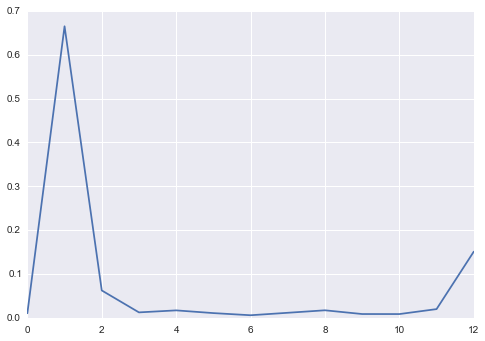

In [107]:
plt.plot(rf.feature_importances_)

In [ ]:
# What do the predictions look like for the snippets where ground truth == 0? 
plt.hist(pred_hard_s[bi_s==0], 50);
print np.sum(bi_s==0), bi_s.shape

In [ ]:
# plotting distributions over lengths of snippets...
for count, key in enumerate(['tp', 'fp', 'tn', 'fn']):
    plt.subplot(2, 2, count+1)
    times = (np.array([xx.shape[0] for xx in sample_results[key]]) / float(pred_y_rescaled.shape[0])) * 60.0
    plt.hist(times)
    plt.title(key + " " + str(times.sum()))

In [ ]:
# now combine all the gt etc into a sound file
for count, key in enumerate(['tp', 'fp', 'tn', 'fn']):
    all_these = np.hstack(sample_results[key])
    print all_these.max(), all_these.min()
    
    # can I normalise volmue?
#     all_these/=all_these.max()
#     all_these *= 2147483647
    
    with open('fp_etc/' + key + '.wav', 'w') as f:
        scipy.io.wavfile.write(f, data=all_these, rate=sr)
    
    

In [ ]:
print 2**16/2